In [1]:
# Import

from __future__ import division
import os
import sys
import copy
import numpy as np
from numpy import ma
import cmasher as cmr
import math as m
import pandas as pd
import string

import pickle
from numpy import genfromtxt
from scipy.interpolate import griddata
from matplotlib import rc
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

import datetime
from matplotlib.dates import DayLocator, MonthLocator, HourLocator, AutoDateLocator, DateFormatter, drange
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from numpy import arange
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.cm as cm
import matplotlib.mlab as mlab

import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#%% Plot Settings

# Colors

darkblue = '#4e79a7'
orange = '#f28e2b'
red = '#e15759'
lightblue = '#76b7b2'
green = '#59a14f'
yellow = '#edc948'
purple = '#b07aa1'
pink = '#ff9da7'
brown = '#9c755f'
gray = '#bab0ac'
darkgray = '#79706e'

cbar_pad = 0.15

# Font / Figure Size
import matplotlib.pylab as pylab
params = {'legend.fontsize': '7',
         'axes.labelsize': '7',
         'axes.titlesize': '7',
         'xtick.labelsize': '7',
         'ytick.labelsize': '7',
          
         'xtick.major.pad': '7',
         'ytick.major.pad': '7',
         'axes.titlepad': 35,
         'axes.labelpad': 15,
         
         'font.sans-serif':'Avenir',
          'axes.linewidth': 0.5,
         'xtick.major.width': 0.5,
         'ytick.major.width': 0.5}
pylab.rcParams.update(params)

In [3]:
def all_nonzero(arr_iter):
    """return non zero elements of all arrays as a np.array"""
    return np.concatenate([a[a != 0] for a in arr_iter])

In [4]:
# toc: total installed cost ($/kWh for energy costs, $/kW for power costs)
# fhc: fixed hourly cost ($/kWh/h for energy costs, $/kW/h for power costs)

hours_per_year = 8760 # number of hours in a year (h/yr)
crf = 0.0806 # capital recovery factor, assuming a discount rate of 7% and 30 year lifetime (%/yr)
fixed_om = 0.015 # Fixed O&M (% of capital cost)
fixed_ptilp = 0.015 # Fixed property tax, insurance, licencing, permiting (% of capital cost)

# functions to calculate fhc from toc of technologies
def get_energy_fhc(toc):
    return ((toc + fixed_om * toc) * crf) / hours_per_year

def get_energy_toc(fhc):
    return (fhc * hours_per_year) / crf / (1 + fixed_om)

def get_power_fhc(toc):
    return ((toc + fixed_ptilp * toc) * crf) / hours_per_year

def get_power_toc(fhc):
    return (fhc * hours_per_year) / crf / (1 + fixed_ptilp)

In [5]:
def reshape(data):
    # X and Y axes
    x = data['third_tech_energy_cost']
    y = data['third_tech_power_cost']
    
    X = list(set(x))
    X.sort()
    Y = list(set(y))
    Y.sort()
    
    for key in data.keys():
        if len(data[key]) > 0:
            data[key] = np.reshape(data[key], (len(Y), len(X)))
    
    data['X'] = X
    data['Y'] = Y

def existence(data):
    epsilon = 10**-3
    data['batt_exist'] = data['battery_cap'] > epsilon
    data['third_tech_exist'] = data['third_tech_energy_cap'] > epsilon
    
    # What is the number of technologies
    data['num_techs'] = sum([data['batt_exist'], data['third_tech_exist']])
    
    # Scatterplot data for if technology exists or not
    data['batt_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['batt_exist']))
    data['batt_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['batt_exist']))
    data['third_tech_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['third_tech_exist']))
    data['third_tech_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['third_tech_exist']))    
    data['both_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['num_techs'] == 2))
    data['both_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['num_techs'] == 2))
            
def prop(data):
    battery_dispatch = data['battery_tot_dispatch']
    third_tech_dispatch = data['third_tech_energy_tot_dispatch']
    tot_dispatch = sum(np.array([battery_dispatch, third_tech_dispatch]))
    data['battery_prop'] = np.divide(battery_dispatch, tot_dispatch)
    data['third_tech_prop'] = np.divide(third_tech_dispatch, tot_dispatch)
    
def storage_cost_cont(data):
    batt = data['batt_cost']
    third_tech = data['third_tech_cost']
    tot_storage_tech_cost = sum(np.array([batt, third_tech]))
    data['batt_cost_cont'] = np.divide(batt, tot_storage_tech_cost)
    data['third_tech_cost_cont'] = np.divide(third_tech, tot_storage_tech_cost)
    data['cost_eff_num_batt'] = np.divide(1, np.square(np.square(data['batt_cost_cont']) + np.square(data['third_tech_cost_cont'])))

In [6]:
# Import Data

from extract_data_param_Li_ion_X import get_data_one_power

# Three tech case

path = '../Output_Data/Param_Two_Techs_Li_ion_X'
data = get_data_one_power(path, 5, 'fixed_cost', 6, 'fixed_cost', False)
                          
data['third_tech_energy_cost'] = [get_energy_toc(i) for i in data['third_tech_energy_cost']]
data['third_tech_power_cost'] = [get_power_toc(i) for i in data['third_tech_power_cost']]

# One tech case
one_tech_path = '../Output_Data/CONUS/Two_Techs_Li-ion_X/Li-ion'
one_tech_data = get_data_one_power(one_tech_path, 2, 'fixed_cost', 3, 'fixed_cost', False)

reshape(data)
existence(data)
prop(data)
storage_cost_cont(data)

In [7]:
# Functions for marking Li-ion and PGP energy/power-capacity total overnight costs

batt_energy_toc = 326.4
batt_power_toc = 250.92

pgp_energy_toc = 1.9992
pgp_power_toc = 1560.6

w=1
l=10

def current_PGP_current_li_ion(ax):
    energy_ticks = ax.twiny()
    energy_ticks.set_xlim(ax.get_xlim())
    energy_ticks.set_xticks([batt_energy_toc])
    energy_ticks.set_xticklabels(['Li-ion'])
    energy_ticks.tick_params(direction='inout', length=l, width=w, pad=2.5)
    
    power_ticks = ax.twinx()
    power_ticks.set_ylim(ax.get_ylim())
    power_ticks.set_yticks([batt_power_toc])
    power_ticks.set_yticklabels(['Li-ion'])
    power_ticks.tick_params(direction='inout', length=l, width=w, pad=2.5)

In [8]:
# Colormap
num_colors = 10
batt_cmap =  colors.LinearSegmentedColormap.from_list("Custom", ['white', purple], N=num_colors)
third_cmap =  colors.LinearSegmentedColormap.from_list("Custom", ['white', darkgray], N=num_colors)
#pgp_cmap = colors.LinearSegmentedColormap.from_list("Custom", ['white', 'indianred'], N=num_colors)

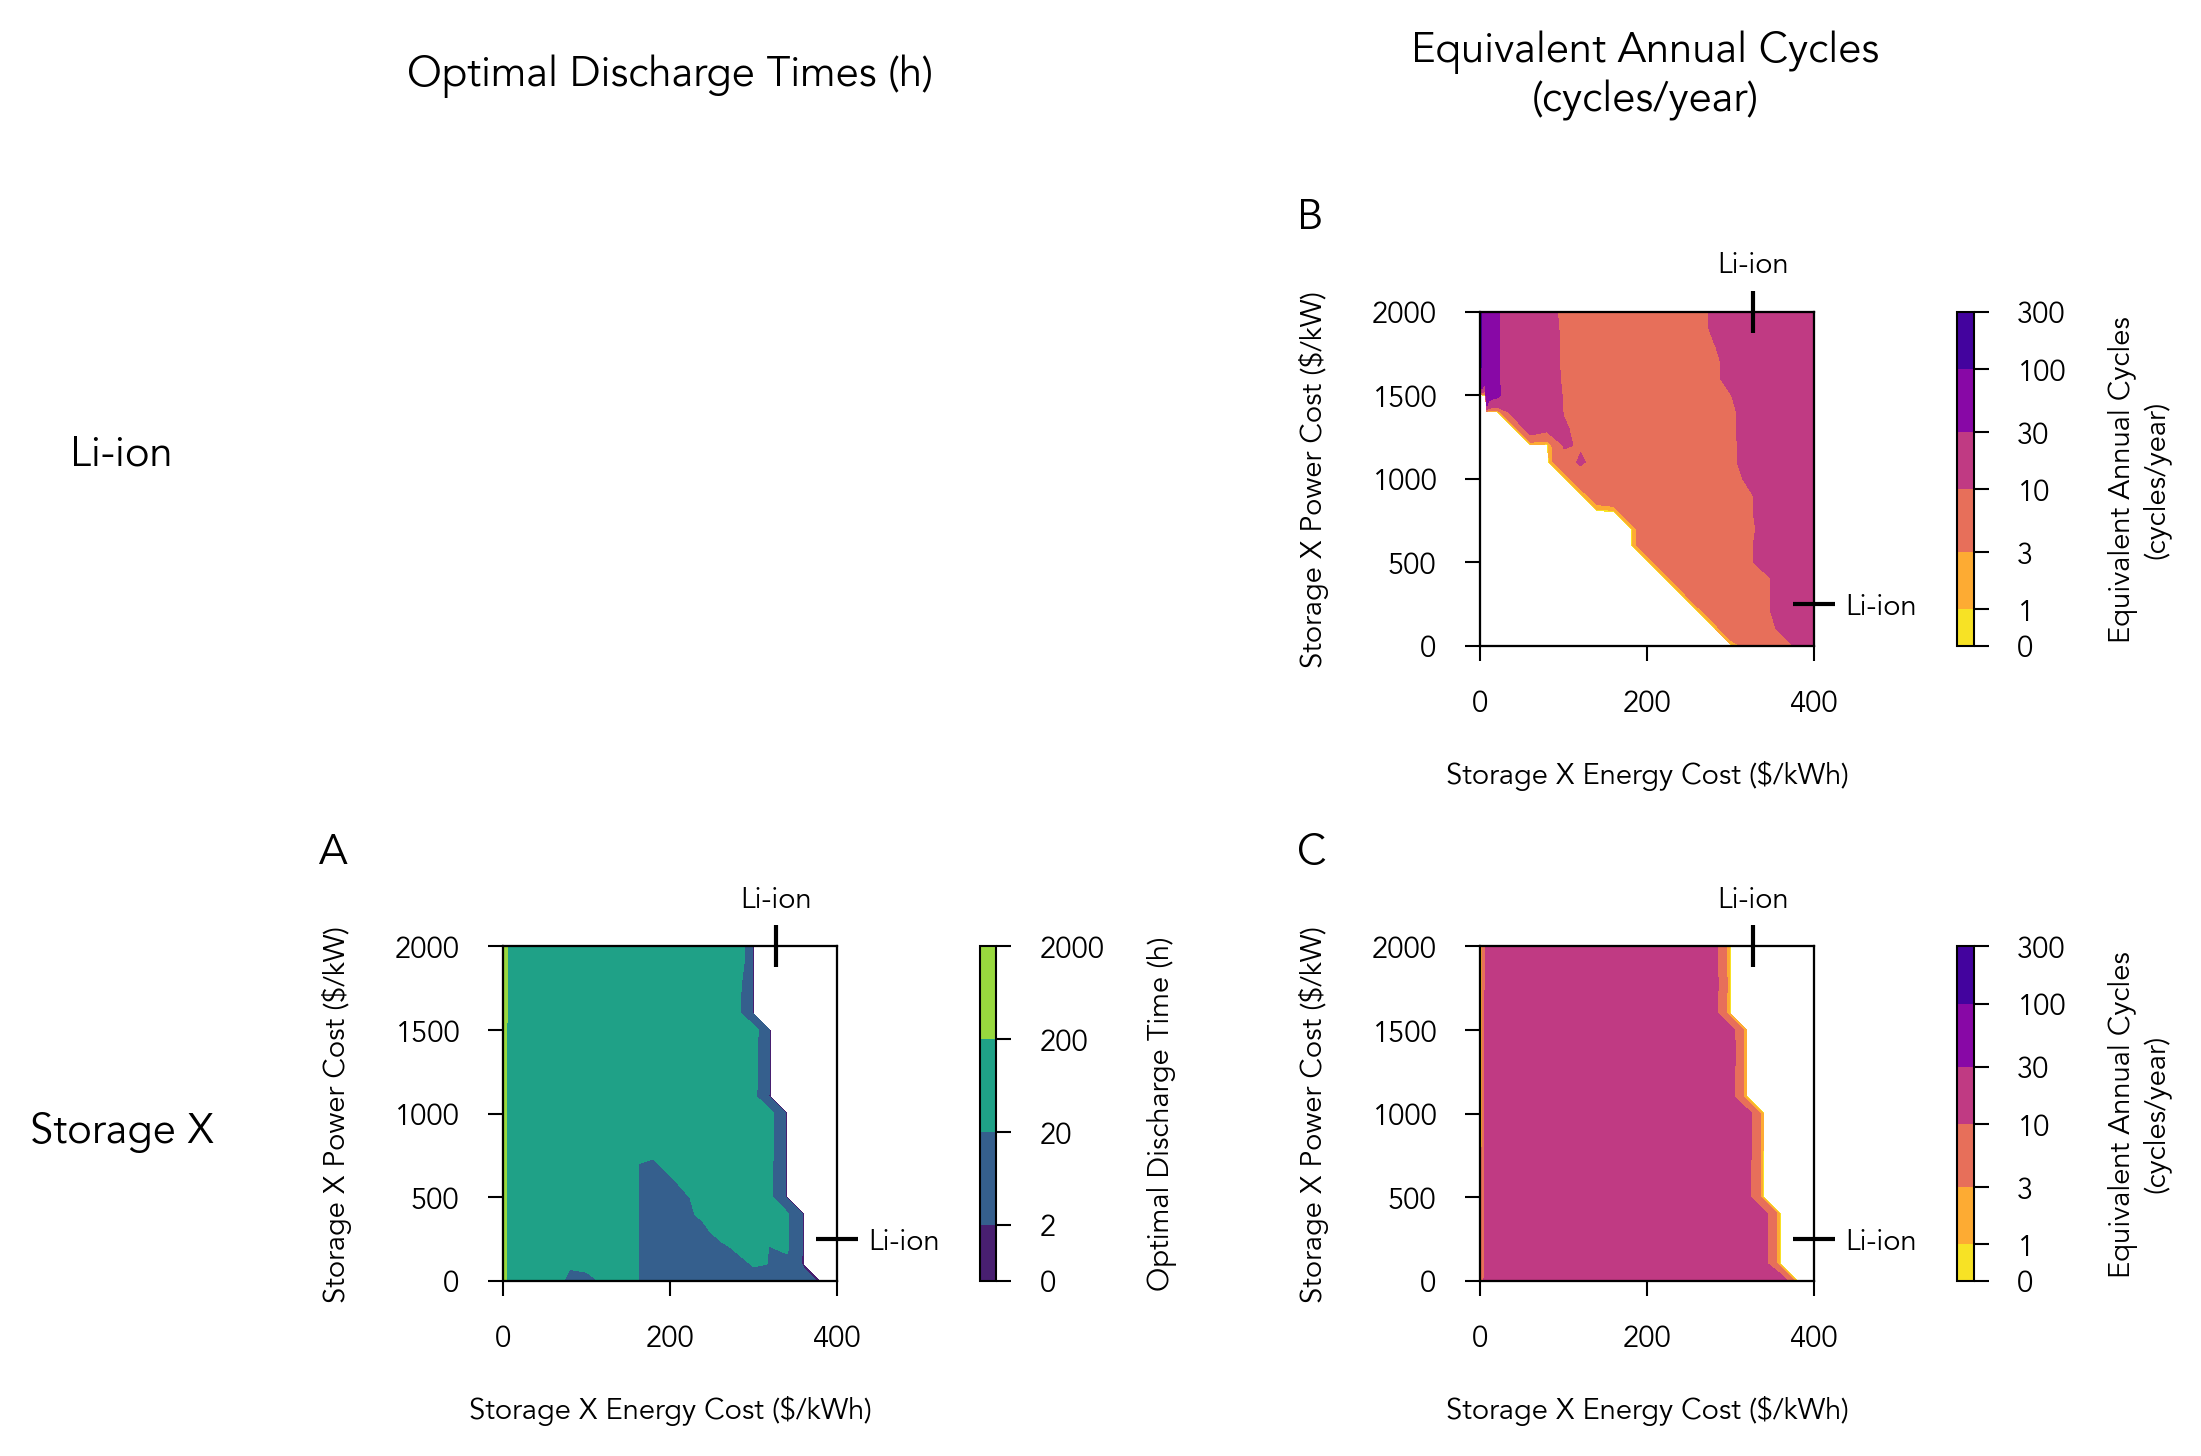

In [9]:
mm = 1/25.4 # millimeters in inches
fig_w = 172*mm
fig_h = 172*mm/1.5
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(fig_w, fig_h), dpi=300)

X = data['X']
Y = data['Y']

discharge_cmap = cmr.get_sub_cmap('viridis', 0, 0.98)
eac_cmap = cmr.get_sub_cmap('plasma_r', 0, 0.98)

discharge_label = 'Optimal Discharge Time (h)'
eac_label = 'Equivalent Annual Cycles\n(cycles/year)'

discharge_levels = [0.499, 2, 20, 200, 2000]
eac_levels = [0.499, 1, 3, 10, 30, 100, 300]

###################################################
#                    Li-ion                       #
###################################################

# Cycles/Year
cpf1 = ax[0,1].contourf(X, Y, data['batt_cycles'], cmap=eac_cmap, levels=eac_levels, locator=ticker.LogLocator())

cbar1 = plt.colorbar(cpf1, ax=ax[0,1], pad=0.1)
cbar1.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
cbar1.ax.set_ylabel(eac_label, labelpad=10)

###################################################
#                    Storage X                    #
###################################################

# Optimal Discharge
cpf2 = ax[1,0].contourf(X, Y, data['third_tech_dur'], cmap=discharge_cmap, levels=discharge_levels, locator=ticker.LogLocator())

cbar2 = plt.colorbar(cpf2, ax=ax[1,0], pad=0.1)
cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
cbar2.ax.set_ylabel(discharge_label, labelpad=10)

# Cycles/Year
cpf3 = ax[1,1].contourf(X, Y, data['third_tech_cycles'], cmap=eac_cmap, levels=eac_levels, locator=ticker.LogLocator())

cbar3 = plt.colorbar(cpf3, ax=ax[1,1], pad=0.1)
cbar3.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
cbar3.ax.set_ylabel(eac_label, labelpad=10)


letters = ['B', 'A', 'C']

# Axis labels, settings
for i, axis in enumerate([ax[0,1], ax[1,0], ax[1,1]]): 
    current_PGP_current_li_ion(axis)
    axis.set_xlim(0, 400)
    axis.set_ylim(0, 2000)
    axis.set_xlabel('Storage X Energy Cost ($/kWh)', labelpad=10)
    axis.set_ylabel('Storage X Power Cost ($/kW)', labelpad=10)
    axis.set_box_aspect(1)
    axis.text(-0.55, 1.25, letters[i], transform=axis.transAxes, fontsize=10, fontweight='bold')

ax[0,0].axis('off')

# Adjust distance between subplots

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.9)

# Outside Labels

fig.text(-0.03, 3/4, 'Li-ion', va='center', ha='center', rotation='horizontal', size=10)
fig.text(-0.03, 1/4, 'Storage X', va='center', ha='center', rotation='horizontal', size=10)
#fig.text(-0.03, 1/6, 'Hydrogen', va='center', ha='center', rotation='horizontal', size=10)

fig.text(0.24, 1.03, 'Optimal Discharge Times (h)', va='center', ha='center', rotation='horizontal', size=10)
fig.text(0.72, 1.03, 'Equivalent Annual Cycles\n(cycles/year)', va='center', ha='center', rotation='horizontal', size=10)


if not os.path.exists('Figures/SI'):
    os.makedirs('Figures/SI')
plt.savefig('Figures/SI/Fig_?_Li-ion_X_Durations_Cycles.png', bbox_inches='tight')

In [15]:
def show_data(parameter):
    pd.set_option('display.max_columns', None)
    df = pd.DataFrame(np.around(data[parameter], decimals=2))
    df = df.iloc[::-1]
    display(df)

In [19]:
show_data('PGP_dur')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
20,43.91,44.85,45.08,56.16,73.68,96.31,762.52,742.98,727.27,715.64,694.34,669.74,640.79,612.04,600.66,521.52,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
19,34.01,36.87,39.22,46.26,56.02,62.79,794.79,787.52,764.36,756.29,729.53,711.99,679.12,658.16,631.27,534.36,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
18,22.62,23.49,23.97,26.12,39.61,49.22,860.37,851.75,823.18,802.13,793.75,770.95,749.98,709.75,682.99,546.97,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
17,4.96,5.46,6.34,7.38,14.13,27.49,876.26,868.89,836.74,797.07,801.49,783.49,771.48,747.20,735.46,578.37,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
16,0.00,0.00,0.00,0.00,2.24,5.48,980.12,889.30,860.31,810.03,804.90,794.40,778.73,762.90,745.86,611.56,531.10,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
15,0.00,0.00,0.00,0.00,0.00,0.00,993.29,868.77,853.88,820.15,808.48,797.88,784.65,774.11,768.71,642.81,538.60,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
14,0.00,0.00,0.00,0.00,0.00,0.00,985.73,840.46,856.30,822.36,811.08,802.69,787.19,778.20,773.02,650.52,558.41,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
13,0.00,0.00,0.00,0.00,0.00,0.00,977.11,839.56,853.64,814.16,807.70,829.50,807.91,782.39,778.20,646.27,587.18,521.98,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
12,0.00,0.00,0.00,0.00,0.00,0.00,961.36,919.97,921.87,868.18,871.78,850.40,834.65,806.51,782.71,642.38,603.88,534.79,521.44,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20
11,0.00,0.00,0.00,0.00,0.00,0.00,1043.80,1062.97,1002.25,905.97,851.03,832.62,844.89,811.85,802.23,651.32,651.34,548.10,520.10,517.14,521.39,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20,522.20


In [ ]:
def all_nonzero(arr_iter):
    """return non zero elements of all arrays as a np.array"""
    return np.concatenate([a[a > 1e-10] for a in arr_iter])

In [ ]:
max(all_nonzero(data['third_tech_dur']))

1009.804321989758

In [ ]:
max(all_nonzero(data['PGP_dur']))

1967.8776363660643